# FOMC Topic Modeling

_Our discussions of the economy may somtimes ring in the ears of the public with more certainty than is appropriate_ - Jerome Powell 

- FOMC meeting minutes
- Tokenization
- Topic models



In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import os
import sklearn.feature_extraction, sklearn.decomposition
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation, NMF
from sklearn.cluster import KMeans
from scipy.special import softmax
from wordcloud import WordCloud
import wordcloud
import matplotlib.pyplot as plt
from finds.database import MongoDB
from finds.unstructured import Unstructured
from finds.utils import Store
from finds.readers import FOMCReader, Alfred
from secret import credentials, paths
# %matplotlib qt
VERBOSE = 0

In [2]:
mongodb = MongoDB(**credentials['mongodb'], verbose=VERBOSE)
fomc = Unstructured(mongodb, 'FOMC')

In [3]:
## retrieve recessions dates for plotting
alf = Alfred(api_key=credentials['fred']['api_key'])
vspans = alf.date_spans(series_id='USREC')

## FOMC minutes

The FOMC holds eight regularly scheduled meetings during the year and other meetings as needed. The minutes of regularly scheduled meetings are released three weeks after the date of the policy decision.

https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm

- keep minutes text approximately from (and including):

  - "Developments in Financial Markets" or
  - "Discussion of Guideliness for Policy Normalization" or
  - "Financial Developments and Open Market Operations" or
  - "discussion of the economic outlook" or
  - "the information reviewed at this meeting" or
  - "the staff presented several briefings" (i.e. staff presentations on ad-hoc policy topics)
  
- skip earlier text which may be
  - re-affirmation of general policy statement
  - organizational items
  
- delete after adjourn line or date scheduled for next meeting, ignore:
  - notation votes, minutes approvals, signature, and footnotes
  - intermeeting conference calls


In [5]:
minutes = FOMCReader()
DataFrame({'dates': len(minutes), 'start': min(minutes), 'end': max(minutes)},
          index=['FOMC minutes'])

,dates,start,end
FOMC minutes,249,19930203,20240320


In [6]:
# retrieve dates stored locally
dates = fomc['minutes'].distinct('date')

In [7]:
# fetch new minutes from FOMC site
docs = {d: minutes(d) for d in minutes if d not in dates}
print('NEW:', ", ".join([f"{k}: {len(v)} chars" for k,v in docs.items()]))

NEW: 


In [8]:
# clean minutes text
def edit(text: str) -> str:
    """helper to spawn editor and write/edit/read to tempfile"""
    import subprocess
    import tempfile
    with tempfile.NamedTemporaryFile(suffix=".tmp") as f: # save temp file
        f.write(text.encode("utf-8"))
        f.flush()
        subprocess.call([os.environ.get('EDITOR','emacs'), "-nw", f.name])
        f.seek(0)
        return f.read().decode("utf-8")        # keep edited text

In [9]:
if docs:
    # to edit out head and tail of each document
    results = list()   
    for date, initial_message in docs.items():   
        edited_text = edit(initial_message)
        results.append({'date': date, 'text' : edited_text})
        results = sorted(results, key = lambda x: x['date'])   # sort by date

    # save edited docs
    Store(paths['scratch'] / 'fomc', ext='gz').dump(results, f"{max(docs.keys())}.json")
    for doc in results: # store docs for new dates
        fomc.insert('minutes', doc, keys=['date'])

In [10]:
# Retrieve all minutes
docs = Series({doc['date']: doc['text'] for doc in fomc.select('minutes')},
              name='minutes').sort_index()
DataFrame(docs)

,minutes
19930203,The Manager of the System Open Market Account ...
19930323,The Deputy Manager for Domestic Operations rep...
19930518,The Manager of the System Open Market Account ...
19930707,The Deputy Manager for Domestic Operations rep...
19930817,The Deputy Manager for Domestic Operations rep...
...,...
20230920,Developments in Financial Markets and Open Mar...
20231101,Developments in Financial Markets and Open Mar...
20231213,Developments in Financial Markets and Open Mar...
20240131,Developments in Financial Markets and Open Mar...


## Tokenization                                                                    
Splitting text into smaller units called __tokens__, which are usually words, but also may be phrases or subwords

### Regular Expressions

A regular expression is a special text spring for describing a text
search pattern to match character combinations in strings.
They are used in tokenization, to find word boundaries and remove whitespace.

Basic regex.
| Expression | Description |
|:--|:--|
| \d | digit from 0 to 9 |
| \w | word character: ASCII letter, digit or underscore |
| \s | whitespace character: space, tab, newline, carriage return, vertical tab |
| \D | character that is not a digit |
| \W | character that is not a word character |
| \S | character that is not a whitespace character |
| [ ... ] | one of the characters in the bracket |
| [a-zA-Z] | one of the characters in the range |
| [^a] | one character that is not `a` |
| [^a-z] | one character that is not in the range |
| \b | word boundary |
| \B | not a word boundary |
| . | any character except line break |
| \\. | the period character |
| \ | escapes a special character: `.*+?$^/\` |
| ^ | start of string: position is an ASCII letter, digit or underscore |
| $ | end of string: position is an ASCII letter, digit or underscore |
| + | quantifier: one or more |
| * | quantifier: zero or more |
| ? | quantifier: zero or one |
| \| | OR operand |
| ( ... ) | capturing group |

### Stopwords                                                                      


In [11]:
# ignore these stop words
StopWords = [w for w in set(wordcloud.STOPWORDS) if "'" not in w]
StopWords += ['january', 'february', 'march', 'april', 'may', 'june',
              'july', 'august', 'september', 'october', 'november',
              'december', 'first', 'second', 'third', 'fourth', 'twelve',
              'participants', 'members', 'meeting']

### Vectorization
Converts text into numerical representations


In [12]:
# To vectorize the input words
ngram_range = (1, 1)   # unigrams
#ngram_range = (2, 2)   # bigrams
#ngram_range = (1, 2)   # unigrams and bigrams
max_df, min_df, max_features = 0.5, 6, 5000 # some reasonable constraints
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    strip_accents='unicode',
    lowercase=True,
    stop_words=StopWords,
    ngram_range=ngram_range,
    max_df=max_df,
    min_df=min_df,
    max_features=max_features,
    token_pattern=r"\b[^\d\W][^\d\W][^\d\W]+\b") #r'\b[^\d\W]+\b'
tf_vectorizer = sklearn.feature_extraction.text.CountVectorizer(
    strip_accents='unicode',
    lowercase=True,
    stop_words=StopWords,
    ngram_range=ngram_range,        # (2, 2) for bigrams
    max_df=max_df,
    min_df=min_df,
    max_features=max_features,
    token_pattern=r"\b[^\d\W][^\d\W][^\d\W]+\b")

## Topic models

TODO

Topic modeling is a statistical technique to discover latent topics
that exist within a collection of documents

- LSA
- LDA
- PLSI
- NMF


In [13]:
# Define models
n_components = 4   # fix number of latent topics
algos = {
    'LSA': (TruncatedSVD(n_components=n_components),
            tfidf_vectorizer),
    'LDA': (LatentDirichletAllocation(n_components=n_components,
                                      learning_method='batch', #'online',
                                      # learning_offset = 50.0,
                                      max_iter = 40,
                                      random_state = 42),
            tf_vectorizer),
    'PLSI': (NMF(n_components=n_components,
                 beta_loss='kullback-leibler',
                 solver='mu', 
                 alpha_W=0.00005,
                 alpha_H=0.00005,
                 l1_ratio=0.5,
                 max_iter=1000,
                 random_state = 42),
             tfidf_vectorizer),
    'NMF': (NMF(n_components=n_components,
                random_state=42,
                beta_loss='frobenius',
                alpha_W=0.00005,
                alpha_H=0.00005,
                l1_ratio=0.5),
            tfidf_vectorizer)}

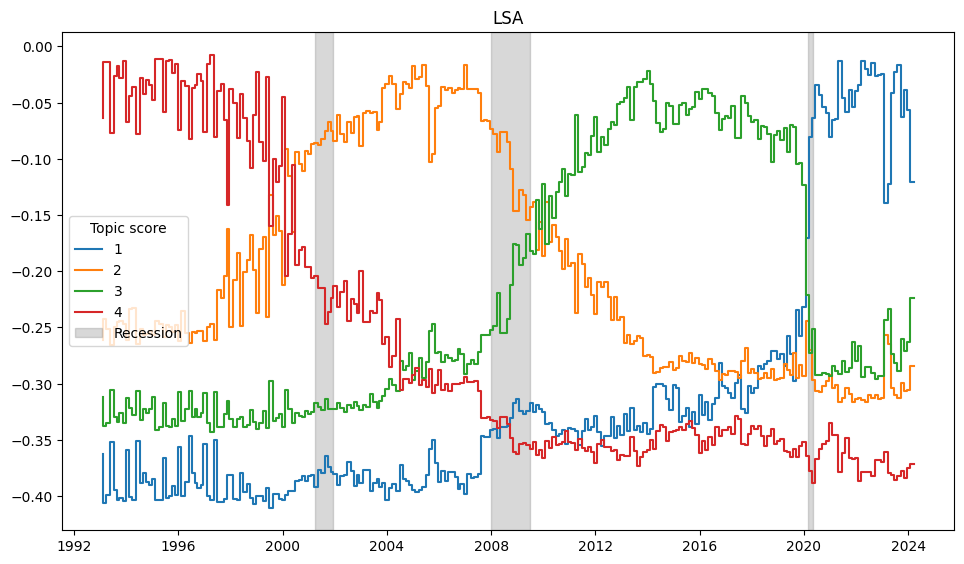

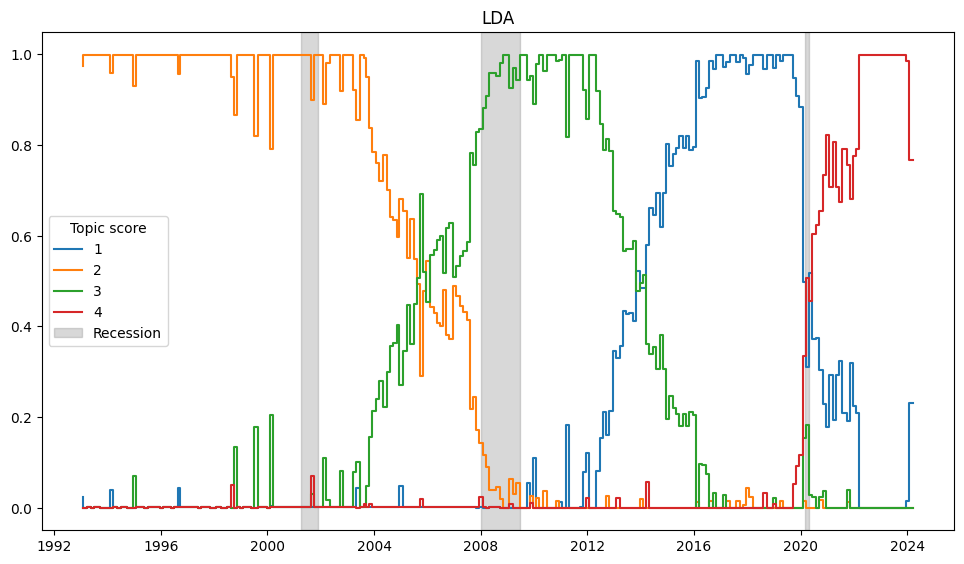

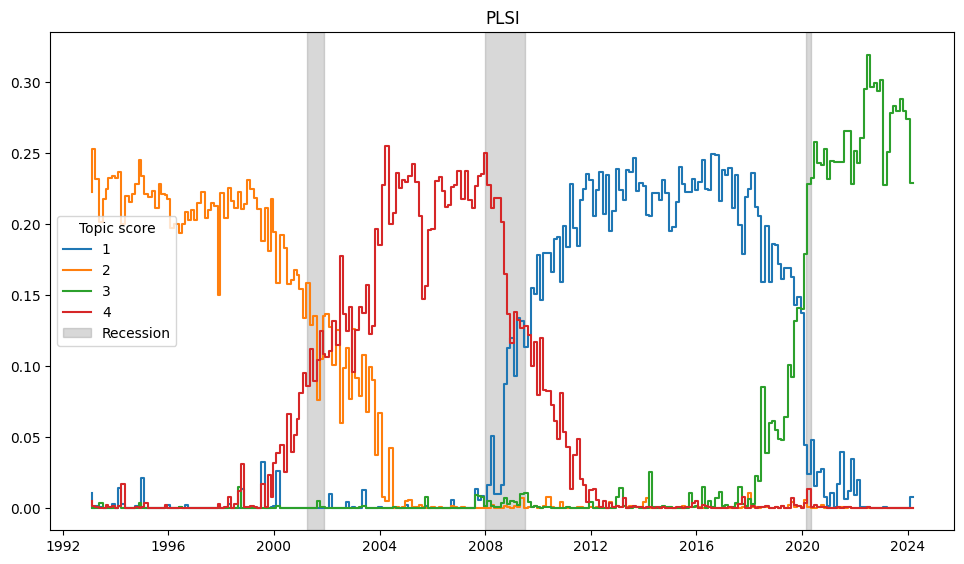

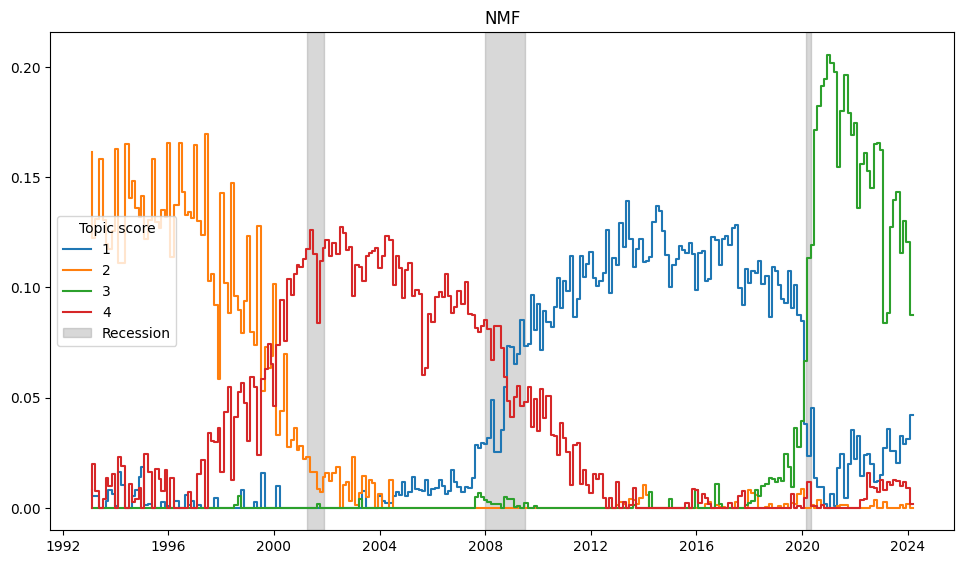

In [16]:
# Fit and plot models
scores = dict()   # to save model coefficients
topics = dict()   # to save dates of primary topic
for ifig, (name, (base, vectorizer)) in enumerate(algos.items()):

    # vectorize the input words
    vectorized = vectorizer.fit_transform(docs.to_list())
    feature_names = vectorizer.get_feature_names_out()

    # fit model and transform inputs
    model = base.fit(vectorized)
    transformed = model.transform(vectorized)

    # save the model fitted coefficients
    if name == 'LSA':  # Additional step for LSA
        kmeans = KMeans(n_clusters=n_components, n_init=5, random_state=37)\
            .fit(transformed)    # find centroids of the latent factors
        transformed = kmeans.transform(transformed)  # distance to centroid
        transformed = -(transformed / transformed.sum(axis=1, keepdims=True))
        scores[name] = softmax(model.components_, axis=1)  # scale word scores
    else:
        scores[name] = model.components_

    # plot topic scores over time
    fig, ax = plt.subplots(num=1 + ifig, clear=True, figsize=(10, 6))
    dates = pd.DatetimeIndex(docs.index.astype(str))        
    ax.step(dates, transformed, where='pre')
    for a,b in vspans:
        if b >= min(dates):
            ax.axvspan(a, min(b, max(dates)), alpha=0.3, color='grey')
    ax.set_title(name)
    ax.legend([f"{i+1}" for i in range(n_components)] + ['Recession'],
              loc='center left', title='Topic score')
    plt.tight_layout(pad=2)

    # save dates of primary topic
    for topic in range(transformed.shape[1]):
        arg = DataFrame({'t': np.argmax(transformed, axis=1),
                         'dt': docs.index})
        dates = (arg!=arg.shift()).cumsum().groupby('t').agg(['first', 'last']) - 1
        dates['topic'] = arg.loc[dates.iloc[:,1], 't'].values
        topics[name] = {topic: [(arg['dt'].iloc[row[0]], arg['dt'].iloc[row[1]])
                                for row in dates.itertuples(index=False, name=None)
                                if row[2] == topic]
                        for topic in range(transformed.shape[1])}

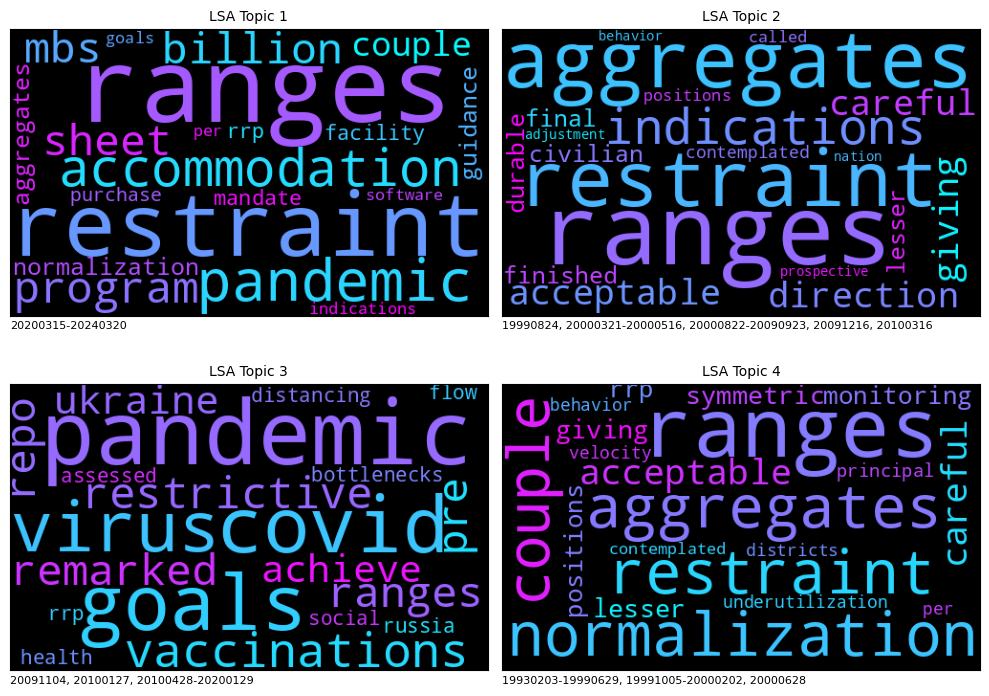

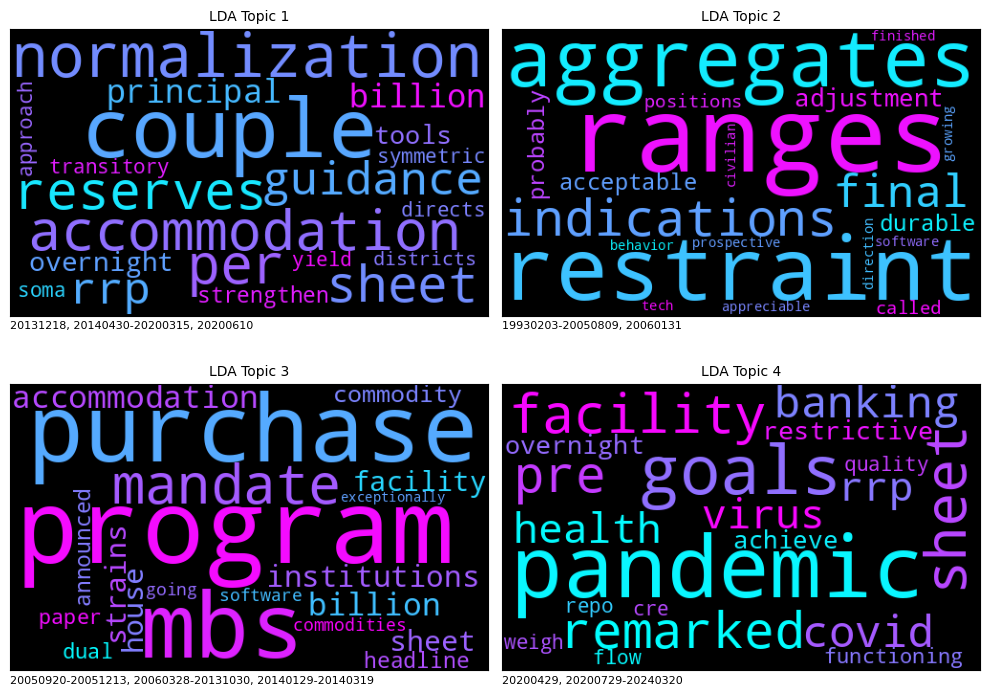

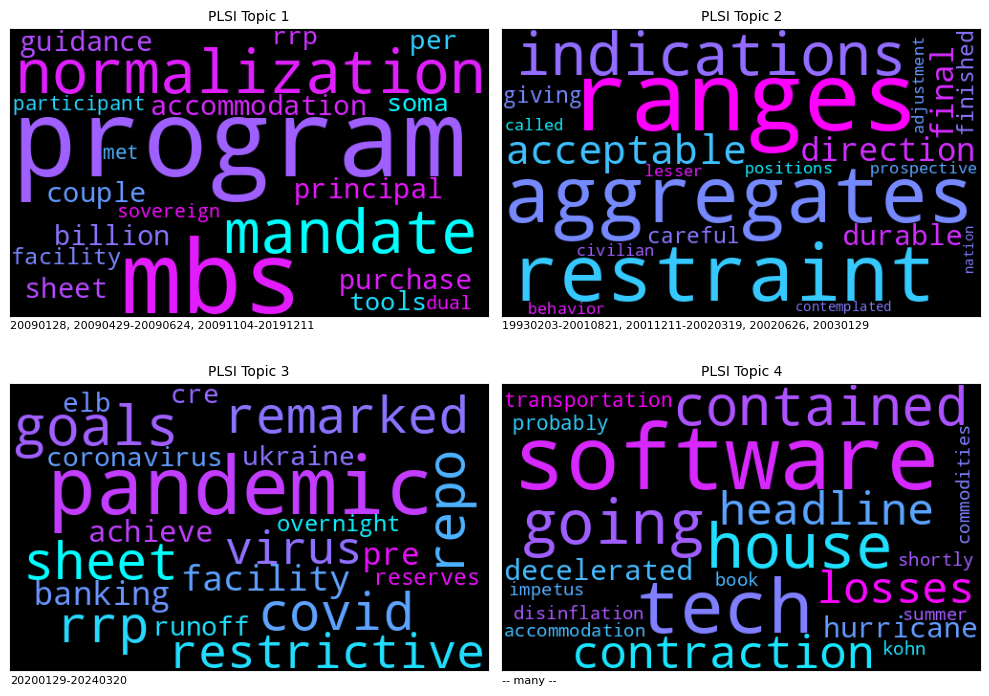

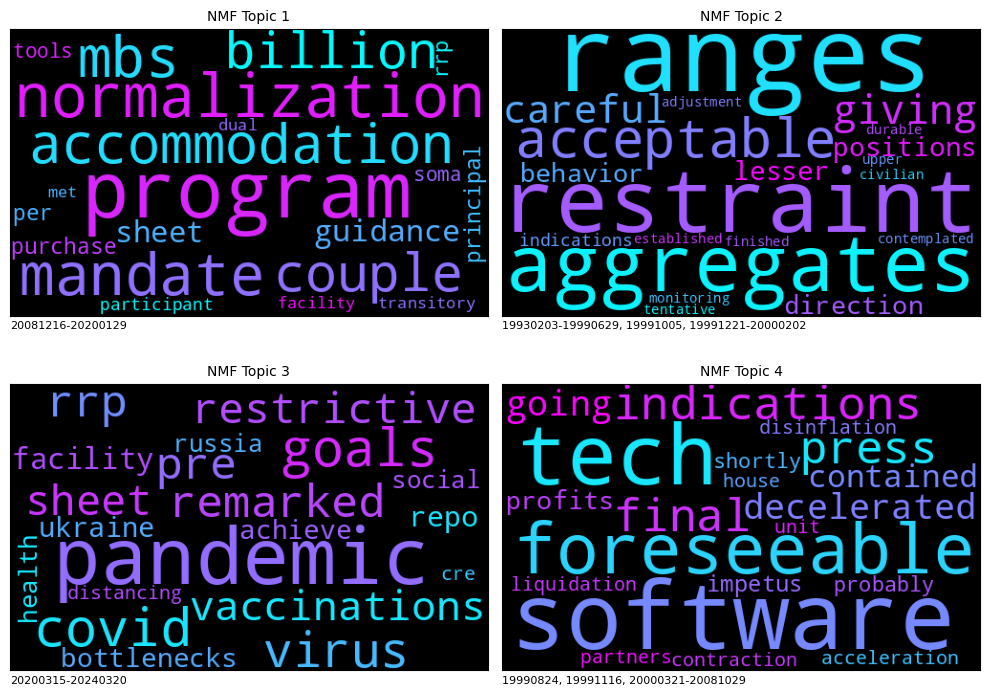

In [15]:
# Display word cloud of top n features
figsize = (10, 8)
for ifig, (name, score) in enumerate(scores.items()):
    wc = WordCloud(height=300, width=500, colormap='cool') 
    top_n = 20
    fig, axes = plt.subplots(2, 2, num=ifig+5, figsize=figsize, clear=True)
    for topic, components in enumerate(score):
        words = {feature_names[i].replace(' ','_') : components[i]
                 for i in components.argsort()[:-top_n - 1:-1]}
        #print("Topic", topic+1, topics[name])
        #print(list(words.keys()))
        ax = axes[topic//2, topic % 2]
        ax.imshow(wc.generate_from_frequencies(words))
        ax.axes.yaxis.set_visible(False)   # make axes ticks invisible
        ax.xaxis.set_ticks([])
        ax.xaxis.set_ticklabels([])
        ax.set_title(f"{name} Topic {topic+1}", fontsize=10)
        regime = ", ".join([f"{d[0]}-{d[1]}" if d[0] != d[1] else f"{d[0]}"
                            for d in topics[name][topic]])            
        ax.set_xlabel(regime if len(regime) < 75 else '-- many --',
                      fontsize=8,
                      loc='left')
        plt.tight_layout()